In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from chefboost import Chefboost as chef

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.impute import KNNImputer
import seaborn as sns

from sklearn.tree import plot_tree

import math

In [ ]:
# Đọc dữ liệu
data = pd.read_csv('/diabetes.csv')


data = data.drop_duplicates()

# Xem 5 dòng đầu tiên
data.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


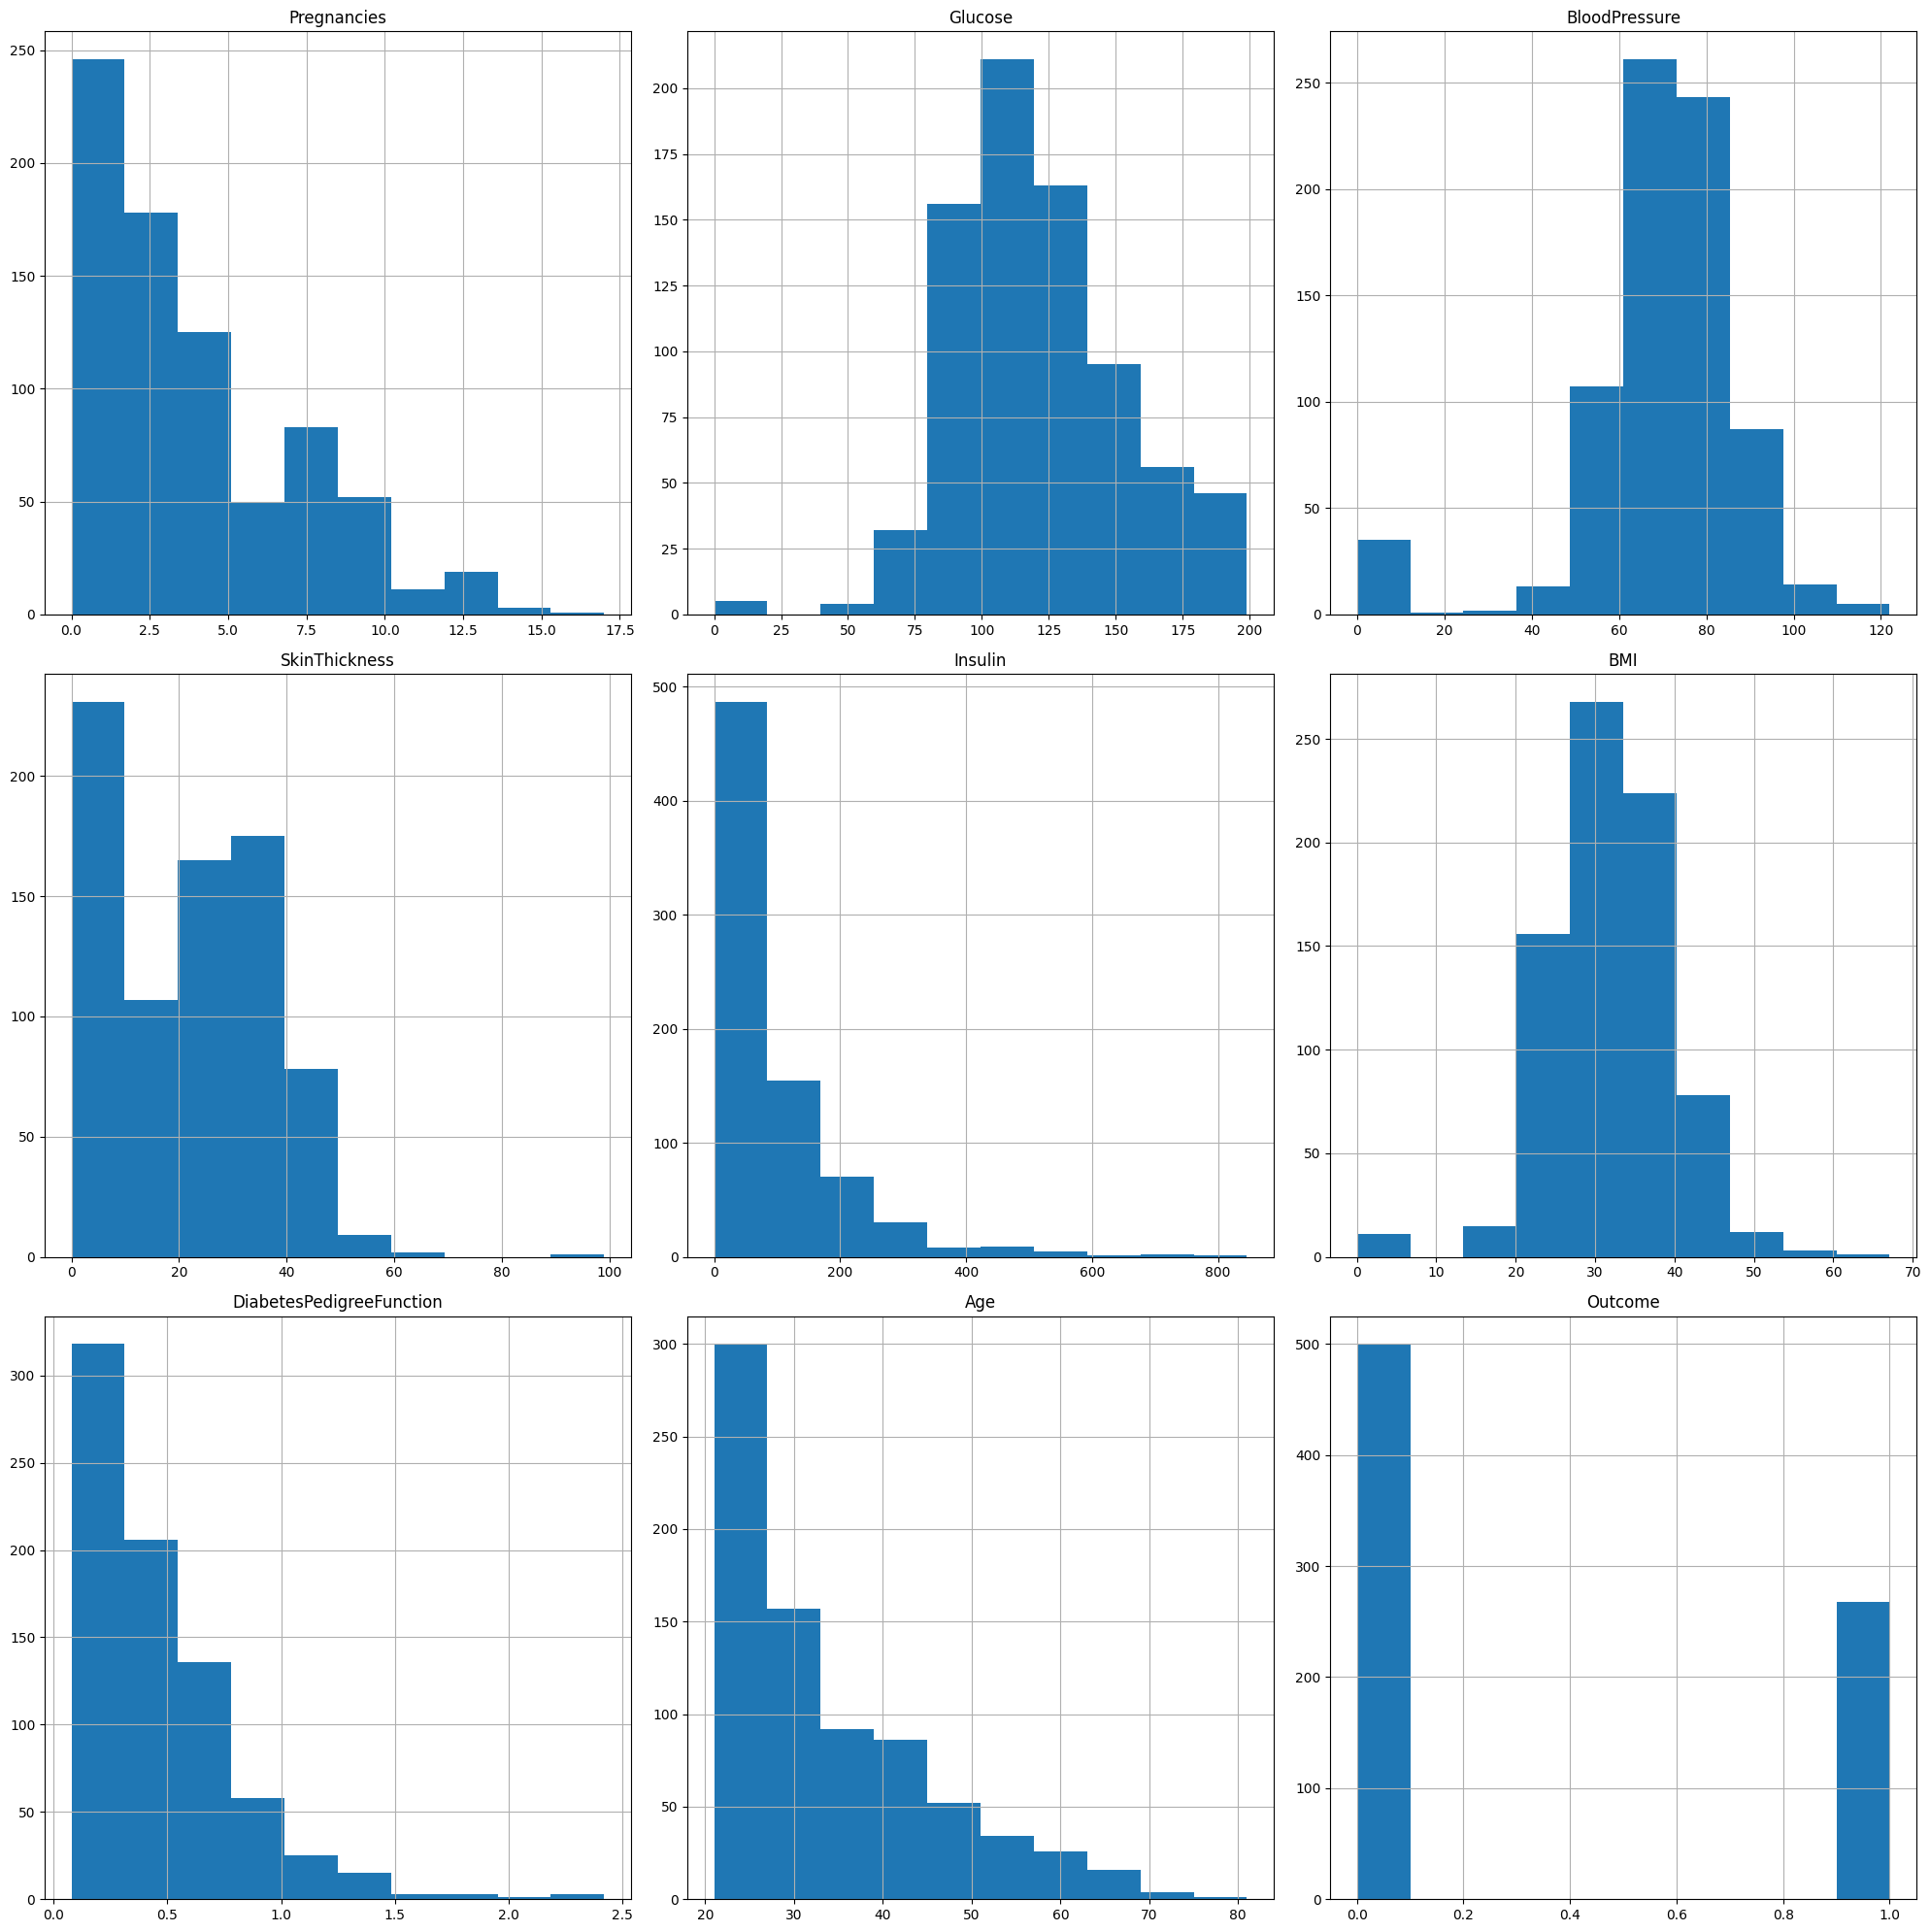

In [ ]:
data.hist(figsize=(20, 20))
plt.tight_layout()
plt.show()

In [ ]:
clean_data_zeros = data.copy()

zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
clean_data_zeros[zero_cols] = clean_data_zeros[zero_cols].replace(0, np.nan)

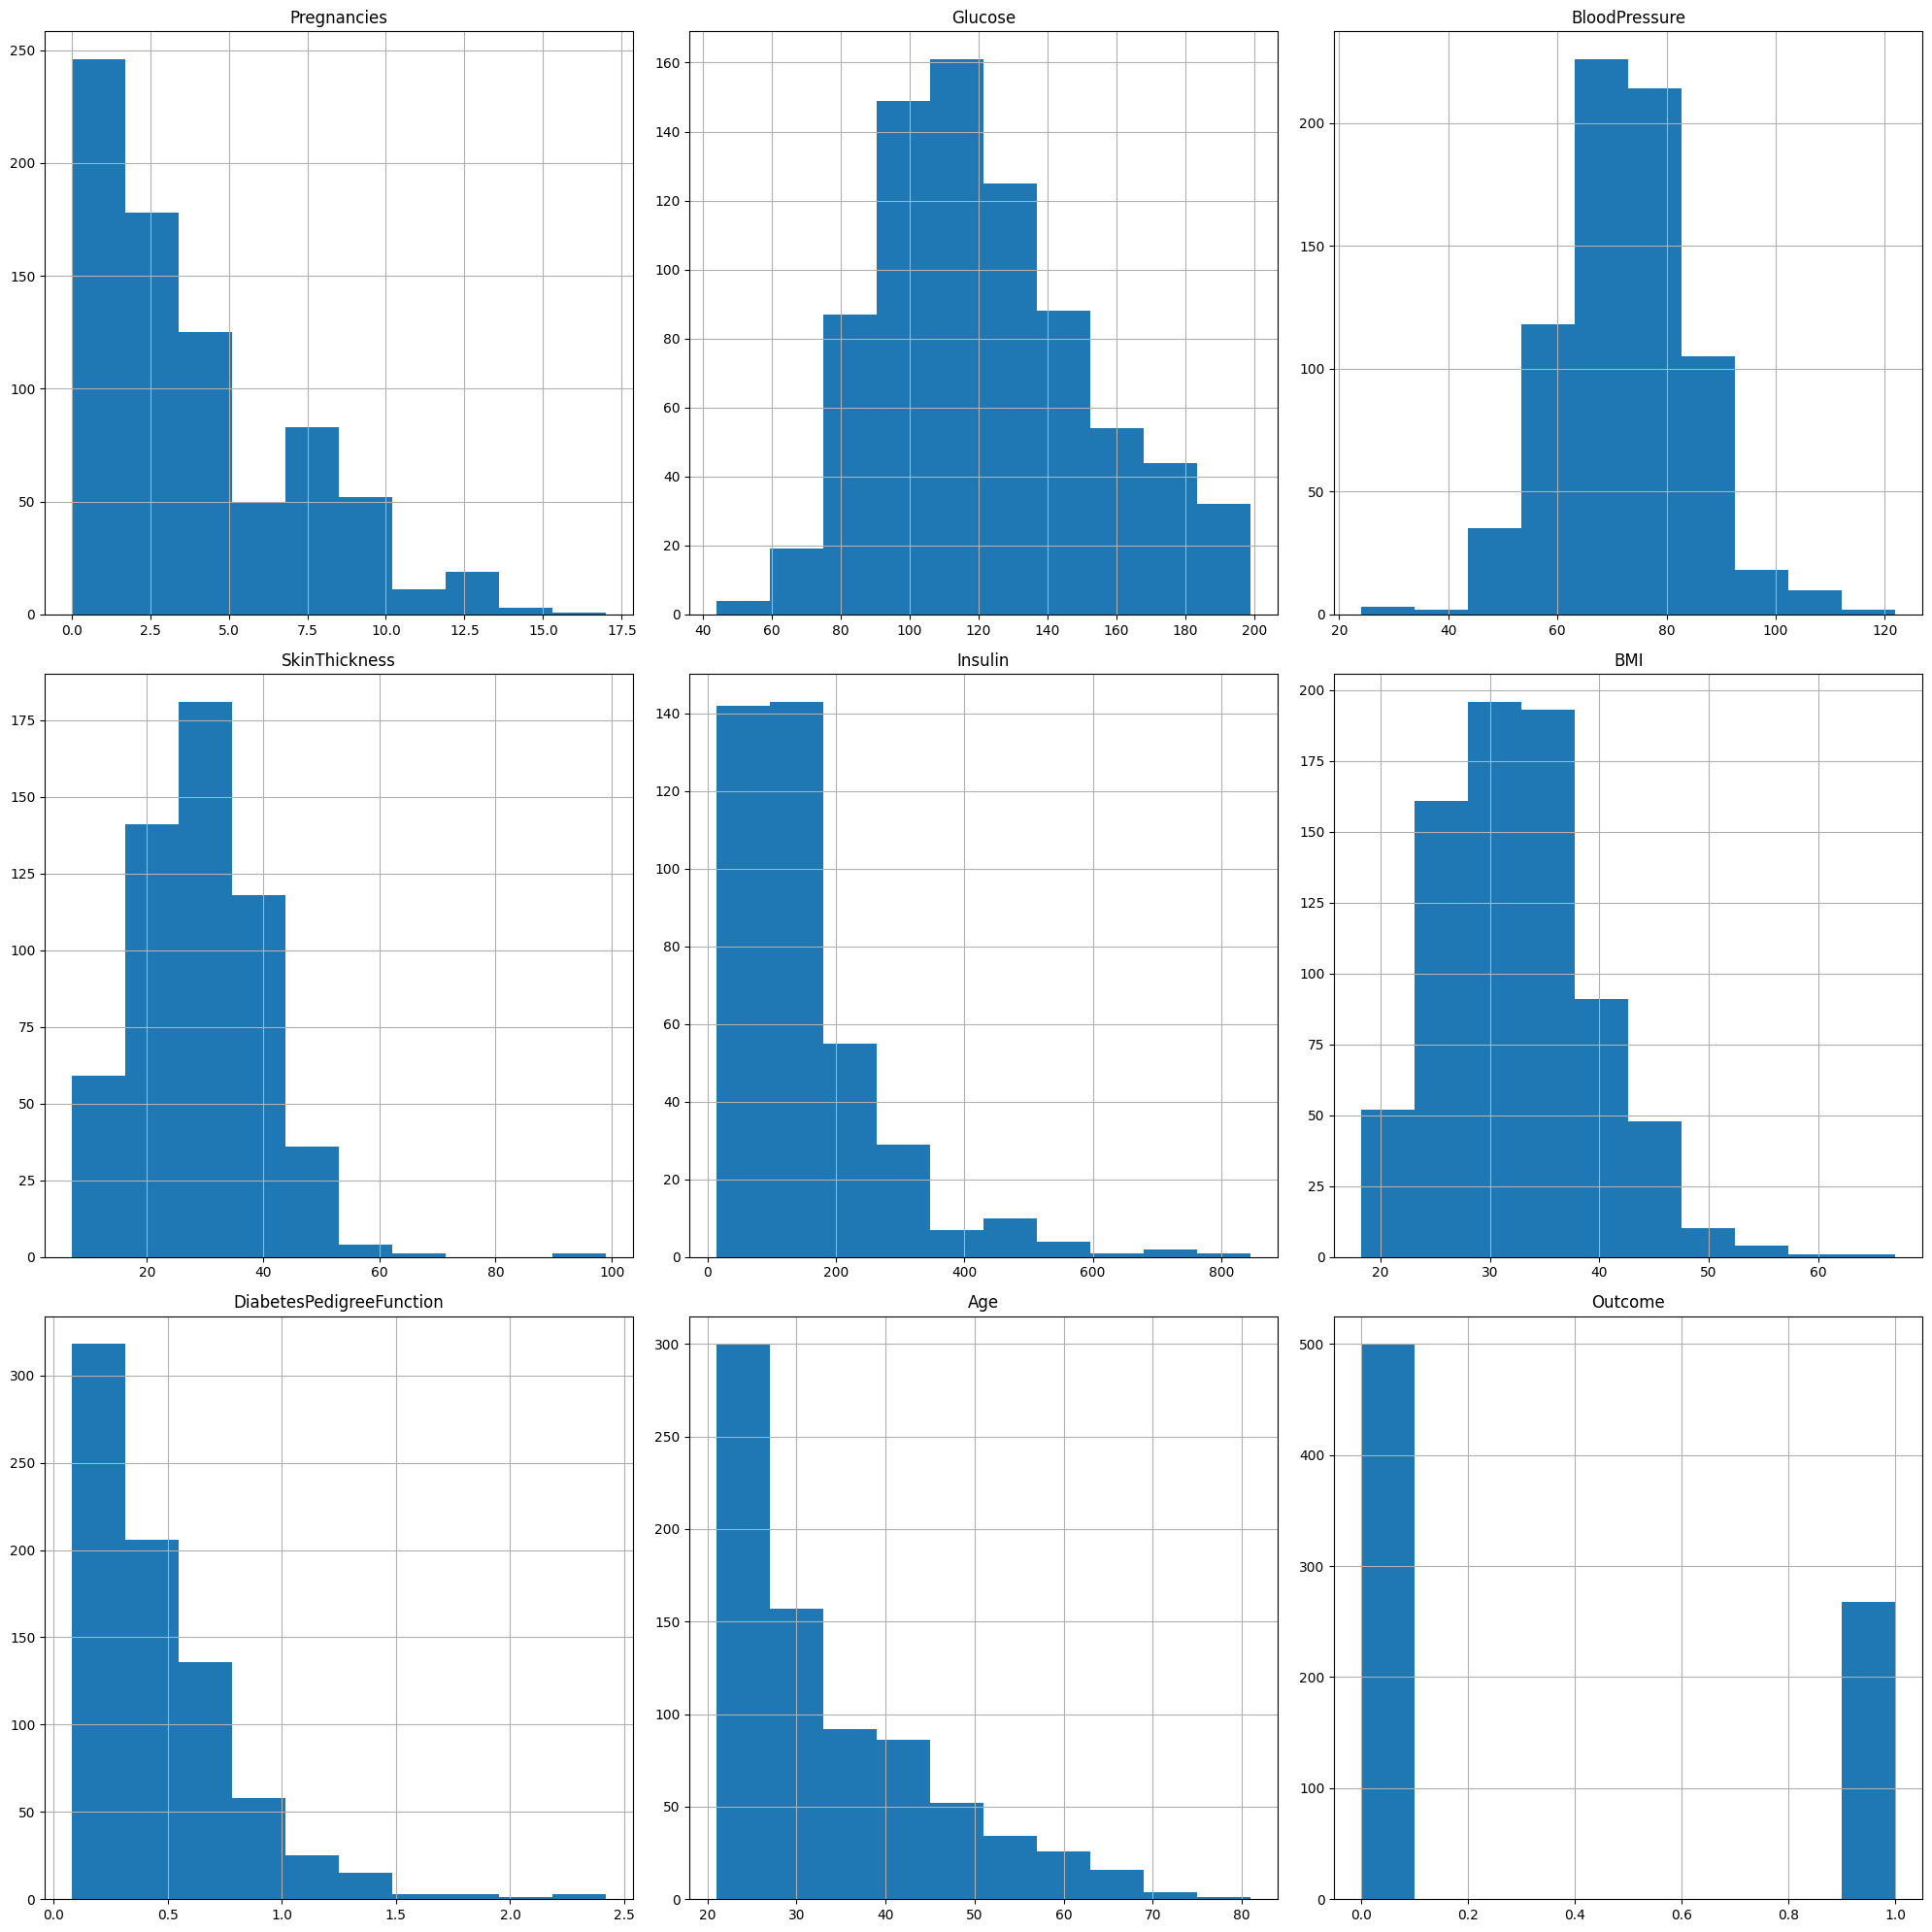

In [ ]:
clean_data_zeros.hist(figsize = (20,20))
plt.tight_layout()

In [ ]:
clean_data_zeros_median = clean_data_zeros.copy()
clean_data_zeros_median[zero_cols] = clean_data_zeros[zero_cols].fillna(clean_data_zeros[zero_cols].median())

imputer = KNNImputer(n_neighbors=5)
clean_data_zeros[zero_cols] = imputer.fit_transform(clean_data_zeros[zero_cols])


In [ ]:
features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
outcome = clean_data_zeros.iloc[:, -1]

In [ ]:

def cap_outliers(df, features):
    for feature in features:

        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR

        df[feature] = df[feature].clip(lower=lower_limit, upper=upper_limit)

    return df

clean_data = cap_outliers(clean_data_zeros, features)

clean_data.tail()

clean_data_zeros_median = cap_outliers(clean_data_zeros_median, features)

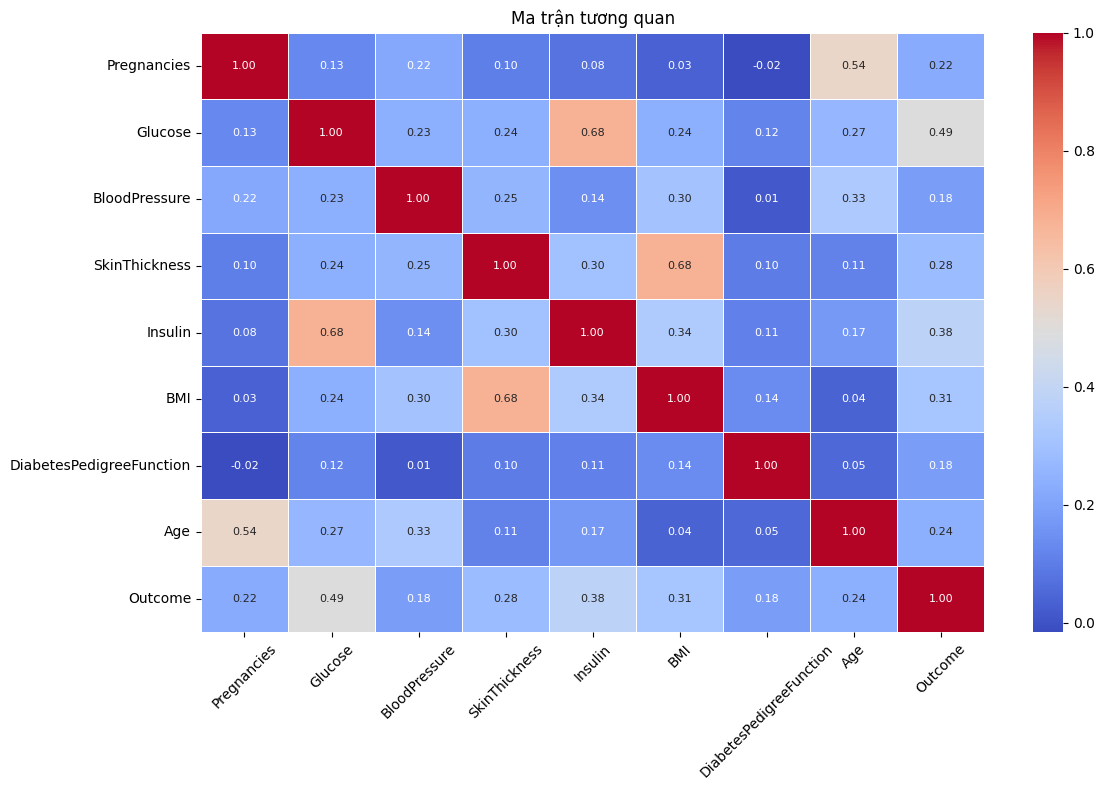

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(clean_data.corr(), annot=True, cmap='coolwarm', fmt='.2f',
            linewidths=0.5, annot_kws={'size': 8})
plt.title('Ma trận tương quan')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
clean_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [ ]:
X = clean_data.drop('Outcome', axis=1).values
y = clean_data['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# --- TÍNH ENTROPY ---
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum([p * math.log2(p) for p in probs if p > 0])

    # --- TÍNH GAIN RATIO ---
def information_gain_ratio(X_column, y):
    threshold = np.median(X_column)

    left_idx = X_column <= threshold
    right_idx = X_column > threshold

    # Thông tin trước chia
    ent_before = entropy(y)

    # Thông tin sau chia
    left_y, right_y = y[left_idx], y[right_idx]
    ent_after = (len(left_y)/len(y)) * entropy(left_y) + (len(right_y)/len(y)) * entropy(right_y)

    # Gain
    info_gain = ent_before - ent_after

    # Split info (phạt các chia quá nhỏ/lệch)
    p_left = len(left_y)/len(y)
    p_right = len(right_y)/len(y)
    split_info = - (p_left * math.log2(p_left) + p_right * math.log2(p_right)) if p_left > 0 and p_right > 0 else 1e-10

    return info_gain / split_info, threshold



# --- NÚT CÂY ---
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature        # Chỉ số cột
        self.threshold = threshold    # Ngưỡng phân chia
        self.left = left              # Nhánh trái
        self.right = right            # Nhánh phải
        self.value = value            # Nếu là lá, giá trị phân lớp

    def is_leaf_node(self):
        return self.value is not None

# --- XÂY CÂY ---
def build_tree(X, y, depth=0, max_depth=5):
    if len(np.unique(y)) == 1:
        return Node(value=int(y[0]))

    if len(y) == 0 or depth >= max_depth:
        return Node(value=int(np.round(np.mean(y))))

    best_gain = -1
    best_feature = None
    best_threshold = None

    for feature_index in range(X.shape[1]):
        gain_ratio, threshold = information_gain_ratio(X[:, feature_index], y)
        if gain_ratio > best_gain:
            best_gain = gain_ratio
            best_feature = feature_index
            best_threshold = threshold

    if best_gain == -1:
        return Node(value=int(np.round(np.mean(y))))

    left_idx = X[:, best_feature] <= best_threshold
    right_idx = X[:, best_feature] > best_threshold

    left = build_tree(X[left_idx], y[left_idx], depth + 1, max_depth)
    right = build_tree(X[right_idx], y[right_idx], depth + 1, max_depth)

    return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)

# --- DỰ ĐOÁN ---
def predict_single(input_data, tree):
    node = tree
    while not node.is_leaf_node():
        if input_data[node.feature] <= node.threshold:
            node = node.left
        else:
            node = node.right
    return node.value

def predict(X, tree):
    return np.array([predict_single(sample, tree) for sample in X])



In [445]:
tree = build_tree(X_train, y_train, max_depth=4)


y_pred = predict(X_test, tree)

print(y_pred)

accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Độ chính xác trên tập test: {accuracy:.2f}")

[1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0
 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0]
Độ chính xác trên tập test: 0.73


In [444]:
from graphviz import Digraph

def visualize_tree(tree, feature_names=None):
    dot = Digraph()
    counter = [0]

    def add_nodes_edges(node, parent=None, edge_label=""):
        node_id = str(counter[0])
        counter[0] += 1

        if node.is_leaf_node():
            label = f"Predict: {node.value}"
        else:
            feat_name = feature_names[node.feature] if feature_names else f"X[{node.feature}]"
            label = f"{feat_name} ≤ {node.threshold:.2f}"

        dot.node(node_id, label)

        if parent is not None:
            dot.edge(parent, node_id, label=edge_label)

        if not node.is_leaf_node():
            add_nodes_edges(node.left, node_id, "yes")
            add_nodes_edges(node.right, node_id, "no")

    add_nodes_edges(tree)
    return dot

    dot = visualize_tree(tree, feature_names=["Pregnancies", "Glucose", "BP", "SkinThickness", "Insulin", "BMI", "DPF", "Age"])
    dot.render("decision_tree", format="png", cleanup=True)  # Xuất ra ảnh PNG
    dot.view()  # Mở ảnh


'decision_tree.pdf'

<Axes: >

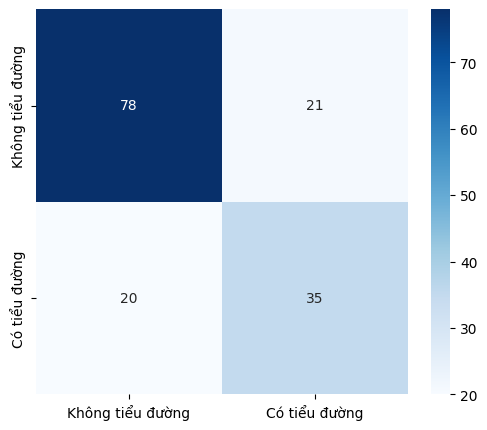

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Tạo biểu đồ heatmap cho ma trận nhầm lẫn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Không tiểu đường", "Có tiểu đường"], yticklabels=["Không tiểu đường", "Có tiểu đường"])


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Không", "Có"]))

              precision    recall  f1-score   support

       Không       0.77      0.90      0.83        99
          Có       0.74      0.53      0.62        55

    accuracy                           0.77       154
   macro avg       0.76      0.71      0.72       154
weighted avg       0.76      0.77      0.76       154

